# Setting Environment

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Utils Functions

In [ ]:
import torch

SEED = 1111
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
from transformers import AutoTokenizer
model_name='SpanBERT/spanbert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


In [ ]:
init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

101 102 0 100


In [ ]:
# max_input_length = tokenizer.max_model_input_sizes[model_name]

# print(max_input_length)

max_input_length = 63

In [ ]:
def tokenize_bert(sentence):
    tokens = tokenizer.tokenize(sentence) 
    return tokens

In [ ]:
def split_and_cut(sentence):
    tokens = sentence.strip().split(" ")
    tokens = tokens[:max_input_length-1]
    return tokens

In [ ]:
def trim_sentence(sent):
    try:
        sent = sent.split()
        sent = sent[:32]
        return " ".join(sent)
    except:
        return sent

# Download Dataset

In [ ]:
!wget https://nlp.stanford.edu/projects/snli/snli_1.0.zip

--2023-05-13 11:53:50--  https://nlp.stanford.edu/projects/snli/snli_1.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94550081 (90M) [application/zip]
Saving to: ‘snli_1.0.zip.1’

snli_1.0.zip.1      100%[===================>]  90.17M  70.7MB/s    in 1.3s    

2023-05-13 11:53:52 (70.7 MB/s) - ‘snli_1.0.zip.1’ saved [94550081/94550081]



In [ ]:
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "snli_1.0.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

File Name                                             Modified             Size
snli_1.0/                                      2015-08-29 08:57:10            0
snli_1.0/.DS_Store                             2015-08-29 08:57:16         6148
__MACOSX/                                      2015-08-29 09:00:04            0
__MACOSX/snli_1.0/                             2015-08-29 09:00:04            0
__MACOSX/snli_1.0/._.DS_Store                  2015-08-29 08:57:16          120
                                 2015-05-21 16:21:08            0
                      2015-05-21 16:21:08       340709
snli_1.0/README.txt                            2015-08-29 08:59:48         5828
__MACOSX/snli_1.0/._README.txt                 2015-08-29 08:59:48          171
snli_1.0/snli_1.0_dev.jsonl                    2015-08-17 10:34:22      9745714
snli_1.0/snli_1.0_dev.txt                      2015-08-17 10:34:24      7565773
snli_1.0/snli_1.0_test.jsonl                   2015-08-17 10:34:26      9730457

# Prepare Dataset

In [ ]:
def get_sent1_token_type(sent):
    try:
        return [0]* len(sent)
    except:
        return []

def get_sent2_token_type(sent):
    try:
        return [1]* len(sent)
    except:
        return []
    
def combine_seq(seq):
    return " ".join(seq)

def combine_mask(mask):
    mask = [str(m) for m in mask]
    return " ".join(mask)

In [ ]:
import pandas as pd

df_train = pd.read_csv('snli_1.0/snli_1.0_train.txt', sep='\t')
df_dev = pd.read_csv('snli_1.0/snli_1.0_dev.txt', sep='\t')
df_test = pd.read_csv('snli_1.0/snli_1.0_test.txt', sep='\t')

df_train = df_train[['gold_label','sentence1','sentence2']]
df_dev = df_dev[['gold_label','sentence1','sentence2']]
df_test = df_test[['gold_label','sentence1','sentence2']]

df_train = df_train[:80000]
df_dev = df_dev[:8000]
df_test = df_test[:8000]
CLS=init_token
SEP=eos_token

df_train['sentence1'] = df_train['sentence1'].apply(trim_sentence)
df_train['sentence2'] = df_train['sentence2'].apply(trim_sentence)
df_dev['sentence1'] = df_dev['sentence1'].apply(trim_sentence)
df_dev['sentence2'] = df_dev['sentence2'].apply(trim_sentence)
df_test['sentence1'] = df_test['sentence1'].apply(trim_sentence)
df_test['sentence2'] = df_test['sentence2'].apply(trim_sentence)

df_train['sent1'] = f'{CLS} ' + df_train['sentence1'] + f' {SEP} '
df_train['sent2'] = df_train['sentence2'] + f' {SEP}'
df_dev['sent1'] = f'{CLS} ' + df_dev['sentence1'] + f' {SEP} '
df_dev['sent2'] = df_dev['sentence2'] + f' {SEP}'
df_test['sent1'] = f'{CLS} ' + df_test['sentence1'] + f' {SEP} '
df_test['sent2'] = df_test['sentence2'] + f' {SEP}'

df_train['sent1_t'] = df_train['sent1'].apply(tokenize_bert)
df_train['sent2_t'] = df_train['sent2'].apply(tokenize_bert)
df_dev['sent1_t'] = df_dev['sent1'].apply(tokenize_bert)
df_dev['sent2_t'] = df_dev['sent2'].apply(tokenize_bert)
df_test['sent1_t'] = df_test['sent1'].apply(tokenize_bert)
df_test['sent2_t'] = df_test['sent2'].apply(tokenize_bert)

df_train['sent1_token_type'] = df_train['sent1_t'].apply(get_sent1_token_type)
df_train['sent2_token_type'] = df_train['sent2_t'].apply(get_sent2_token_type)
df_dev['sent1_token_type'] = df_dev['sent1_t'].apply(get_sent1_token_type)
df_dev['sent2_token_type'] = df_dev['sent2_t'].apply(get_sent2_token_type)
df_test['sent1_token_type'] = df_test['sent1_t'].apply(get_sent1_token_type)
df_test['sent2_token_type'] = df_test['sent2_t'].apply(get_sent2_token_type)

df_train['sequence'] = df_train['sent1_t'] + df_train['sent2_t']
df_dev['sequence'] = df_dev['sent1_t'] + df_dev['sent2_t']
df_test['sequence'] = df_test['sent1_t'] + df_test['sent2_t']


df_train['attention_mask'] = df_train['sequence'].apply(get_sent2_token_type)
df_dev['attention_mask'] = df_dev['sequence'].apply(get_sent2_token_type)
df_test['attention_mask'] = df_test['sequence'].apply(get_sent2_token_type)

df_train['token_type'] = df_train['sent1_token_type'] + df_train['sent2_token_type']
df_dev['token_type'] = df_dev['sent1_token_type'] + df_dev['sent2_token_type']
df_test['token_type'] = df_test['sent1_token_type'] + df_test['sent2_token_type']

df_train['sequence'] = df_train['sequence'].apply(combine_seq)
df_dev['sequence'] = df_dev['sequence'].apply(combine_seq)
df_test['sequence'] = df_test['sequence'].apply(combine_seq)

df_train['attention_mask'] = df_train['attention_mask'].apply(combine_mask)
df_dev['attention_mask'] = df_dev['attention_mask'].apply(combine_mask)
df_test['attention_mask'] = df_test['attention_mask'].apply(combine_mask)

df_train['token_type'] = df_train['token_type'].apply(combine_mask)
df_dev['token_type'] = df_dev['token_type'].apply(combine_mask)
df_test['token_type'] = df_test['token_type'].apply(combine_mask)

df_train = df_train[['gold_label', 'sequence', 'attention_mask', 'token_type']]
df_dev = df_dev[['gold_label', 'sequence', 'attention_mask', 'token_type']]
df_test = df_test[['gold_label', 'sequence', 'attention_mask', 'token_type']]



df_train = df_train.loc[df_train['gold_label'].isin(['entailment','contradiction','neutral'])]
df_dev = df_dev.loc[df_dev['gold_label'].isin(['entailment','contradiction','neutral'])]
df_test = df_test.loc[df_test['gold_label'].isin(['entailment','contradiction','neutral'])]



df_train.to_csv('snli_1.0/snli_1.0_train.csv', index=False)
df_dev.to_csv('snli_1.0/snli_1.0_dev.csv', index=False)
df_test.to_csv('snli_1.0/snli_1.0_test.csv', index=False)

In [ ]:
print(df_train.iloc[0]['sequence'])
print(df_train.iloc[0]['attention_mask'])
print(df_train.iloc[0]['token_type'])

[CLS] a person on a horse jumps over a broken down airplane . [SEP] a person is training his horse for a competition . [SEP]
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1


In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
def convert_to_int(tok_ids):
    tok_ids = [int(x) for x in tok_ids]
    return tok_ids

In [ ]:
def padding_tokens(tokens,pd_tkn):
    if(len(tokens)<max_input_length-1):
        for i in range(max_input_length-1 -len(tokens)):
            tokens.append(pd_tkn)
    return tokens

label2index = {"entailment":0,"neutral":1,"contradiction":2}

train_data = {}
train_data['sequence'] = []
train_data['attention_mask']=[]
train_data['token_type']=[]
train_data['gold_label']=[]

for data_t in df_train['sequence']:
  tokens = split_and_cut(data_t)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
#   print(len(token_ids),end=" ")
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
#   print(len(pd_tokens),end=" /")
  train_data['sequence'].append(pd_tokens)

for data_t in df_train['attention_mask']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  train_data['attention_mask'].append(pd_tokens)

for data_t in df_train['token_type']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,1)
  train_data['token_type'].append(pd_tokens)

for t in df_train['gold_label']:
    train_data['gold_label'].append(label2index[t])

#valid data
valid_data = {}
valid_data['sequence'] = []
valid_data['attention_mask']=[]
valid_data['token_type']=[]
valid_data['gold_label']=[]

for data_t in df_dev['sequence']:
  tokens = split_and_cut(data_t)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  valid_data['sequence'].append(pd_tokens)

for data_t in df_dev['attention_mask']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  valid_data['attention_mask'].append(pd_tokens)

for data_t in df_dev['token_type']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,1)
  valid_data['token_type'].append(pd_tokens)

for t in df_dev['gold_label']:
    valid_data['gold_label'].append(label2index[t])

test_data = {}
test_data['sequence'] = []
test_data['attention_mask']=[]
test_data['token_type']=[]
test_data['gold_label']=[]

for data_t in df_test['sequence']:
  tokens = split_and_cut(data_t)
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  test_data['sequence'].append(pd_tokens)

for data_t in df_test['attention_mask']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,pad_token_idx)
  test_data['attention_mask'].append(pd_tokens)

for data_t in df_test['token_type']:
  tokens = split_and_cut(data_t)
  token_ids = convert_to_int(tokens)
  pd_tokens = padding_tokens(token_ids,1)
  test_data['token_type'].append(pd_tokens)

for t in df_test['gold_label']:
    test_data['gold_label'].append(label2index[t])






In [ ]:
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def getDataloader(dataset):
    # print(len(dataset["premise"]))
    # for i in dataset["sequence"][:100]:
    #     print(len(i),end=" ")
    sequence = torch.tensor(dataset["sequence"],dtype=torch.long)
    attention_mask = torch.tensor(dataset["attention_mask"],dtype=torch.long)
    token_type = torch.tensor(dataset["token_type"],dtype=torch.long)
    labels = torch.tensor(dataset["gold_label"],dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(sequence,attention_mask,token_type,labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    return dataloader
  
train_dataloader = getDataloader(train_data)
valid_dataloader = getDataloader(valid_data)
test_dataloader = getDataloader(test_data)

In [ ]:
from transformers import AutoModel

bert_model = AutoModel.from_pretrained(model_name,output_hidden_states=True)

Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.nn as nn

class BERTNLIModel(nn.Module):
    def __init__(self,
                 bert_model,
                 hidden_dim,
                 output_dim,
                ):
        
        super().__init__()
        
        self.bert = bert_model
        
        embedding_dim = bert_model.config.hidden_size

        self.out = nn.Linear(embedding_dim, output_dim)
        
        
    def forward(self, sequence, attn_mask, token_type):
        
                
        embedded = self.bert(input_ids = sequence, attention_mask = attn_mask, token_type_ids= token_type)[1]    
        
        output = self.out(embedded)

        
        return output

In [ ]:
HIDDEN_DIM = 512
OUTPUT_DIM = len(label2index)

model = BERTNLIModel(bert_model,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                        ).to(device)

In [ ]:
from transformers import *

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attenti

In [ ]:
import torch.optim as optim

#optimizer = optim.Adam(model.parameters())
optimizer = AdamW(model.parameters(),lr=2e-5,eps=1e-6,correct_bias=False)

def get_scheduler(optimizer, warmup_steps):
    scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)
    return scheduler

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
from tqdm import tqdm

In [ ]:
def categorical_accuracy(preds, y):
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = (max_preds.squeeze(1)==y).float()
    return correct.sum() / len(y)

In [ ]:
max_grad_norm = 1

def train(model, iterator, optimizer, criterion, scheduler):
    #print(iterator)
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for sequence,attn_mask,token_type,label in tqdm(iterator):

        optimizer.zero_grad() # clear gradients first
        torch.cuda.empty_cache() # releases all unoccupied cached memory 
        
        sequence,attn_mask,token_type,label = sequence.to(device),attn_mask.to(device),token_type.to(device),label.to(device)
        
        predictions = model(sequence, attn_mask, token_type)
        
        
        loss = criterion(predictions, label)
        
        acc = categorical_accuracy(predictions, label)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

def evaluate(model, iterator, criterion):
    #print(iterator)
    epoch_loss = 0
    epoch_acc = 0
    y_true = []
    y_pred = []
    model.eval()
    
    with torch.no_grad():
    
        for sequence,attn_mask,token_type,labels in tqdm(iterator):

            sequence,attn_mask,token_type,labels = sequence.to(device),attn_mask.to(device),token_type.to(device),labels.to(device)
            predictions = model(sequence, attn_mask, token_type)
            y_true.extend(labels.cpu())
            y_pred.extend(predictions.cpu().argmax(1))
            loss = criterion(predictions, labels)
                
            acc = categorical_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        print("Test Classification report")
        print(classification_report(y_true, y_pred, target_names=["entailment","neutral","contradiction"]))
        cf_matrix = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in ["entailment","neutral","contradiction"]],columns = [i for i in ["entailment","neutral","contradiction"]])
        # plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True)
        plt.savefig('output.png')
        plt.show()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

100%|██████████| 492/492 [00:29<00:00, 16.65it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.88      0.90      0.89      2672
      neutral       0.85      0.80      0.82      2569
contradiction       0.85      0.88      0.87      2626

     accuracy                           0.86      7867
    macro avg       0.86      0.86      0.86      7867
 weighted avg       0.86      0.86      0.86      7867



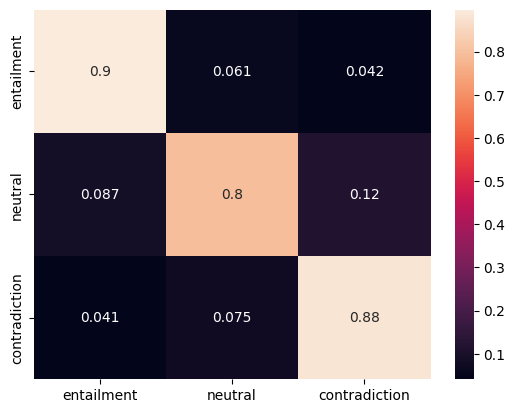

Epoch: 01 | Epoch Time: 18m 5s
	Train Loss: 0.590 | Train Acc: 75.79%
	 Val. Loss: 0.387 |  Val. Acc: 85.94%


100%|██████████| 492/492 [00:29<00:00, 16.65it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.87      0.92      0.89      2672
      neutral       0.86      0.81      0.84      2569
contradiction       0.90      0.88      0.89      2626

     accuracy                           0.87      7867
    macro avg       0.87      0.87      0.87      7867
 weighted avg       0.87      0.87      0.87      7867



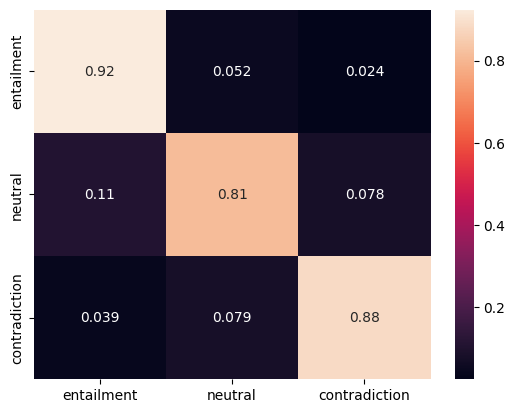

Epoch: 02 | Epoch Time: 18m 10s
	Train Loss: 0.392 | Train Acc: 85.45%
	 Val. Loss: 0.348 |  Val. Acc: 87.43%


100%|██████████| 492/492 [00:29<00:00, 16.67it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.92      0.88      0.90      2672
      neutral       0.83      0.86      0.84      2569
contradiction       0.89      0.90      0.89      2626

     accuracy                           0.88      7867
    macro avg       0.88      0.88      0.88      7867
 weighted avg       0.88      0.88      0.88      7867



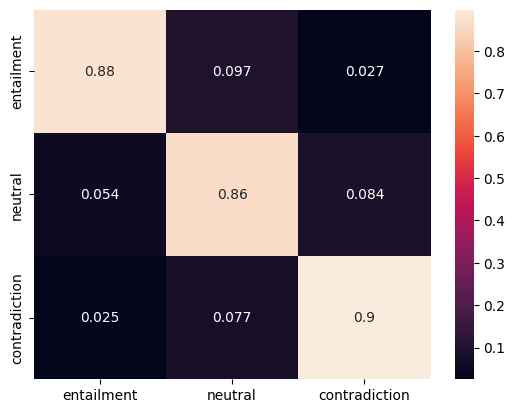

Epoch: 03 | Epoch Time: 18m 9s
	Train Loss: 0.301 | Train Acc: 89.23%
	 Val. Loss: 0.353 |  Val. Acc: 87.92%


100%|██████████| 492/492 [00:29<00:00, 16.69it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.91      0.87      0.89      2672
      neutral       0.81      0.89      0.85      2569
contradiction       0.92      0.88      0.90      2626

     accuracy                           0.88      7867
    macro avg       0.88      0.88      0.88      7867
 weighted avg       0.88      0.88      0.88      7867



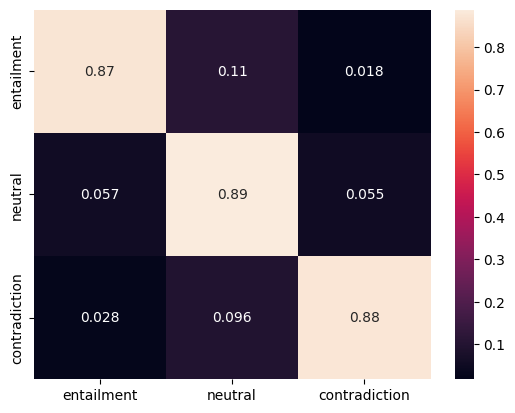

Epoch: 04 | Epoch Time: 18m 9s
	Train Loss: 0.234 | Train Acc: 91.96%
	 Val. Loss: 0.365 |  Val. Acc: 87.94%


100%|██████████| 492/492 [00:29<00:00, 16.65it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.93      0.83      0.88      2672
      neutral       0.82      0.86      0.84      2569
contradiction       0.87      0.92      0.89      2626

     accuracy                           0.87      7867
    macro avg       0.87      0.87      0.87      7867
 weighted avg       0.87      0.87      0.87      7867



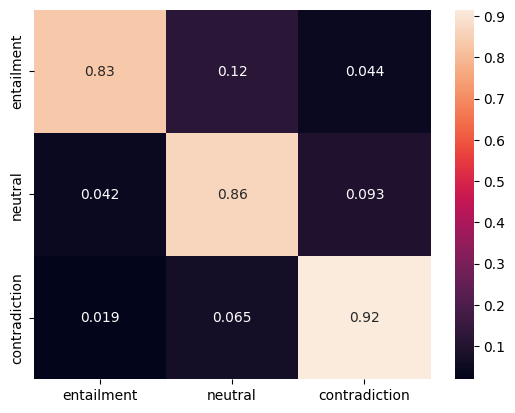

Epoch: 05 | Epoch Time: 18m 9s
	Train Loss: 0.183 | Train Acc: 93.81%
	 Val. Loss: 0.464 |  Val. Acc: 87.15%


100%|██████████| 492/492 [00:29<00:00, 16.74it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.89      0.90      0.89      2672
      neutral       0.85      0.82      0.84      2569
contradiction       0.89      0.90      0.90      2626

     accuracy                           0.88      7867
    macro avg       0.88      0.88      0.88      7867
 weighted avg       0.88      0.88      0.88      7867



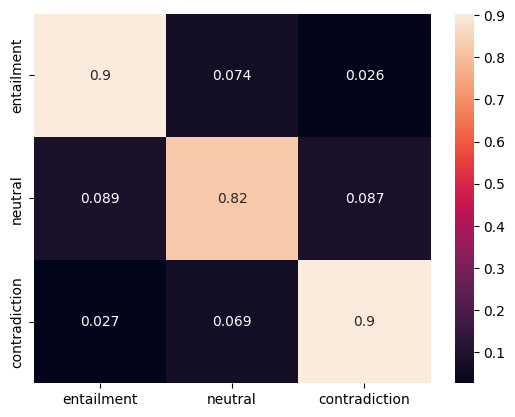

Epoch: 06 | Epoch Time: 18m 9s
	Train Loss: 0.147 | Train Acc: 95.19%
	 Val. Loss: 0.445 |  Val. Acc: 87.66%


In [30]:
import math
N_EPOCHS = 6

warmup_percent = 0.2
total_steps = math.ceil(N_EPOCHS*len(train_data['sequence'])*1./BATCH_SIZE)
warmup_steps = int(total_steps*warmup_percent)
scheduler = get_scheduler(optimizer, warmup_steps)

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, scheduler)
    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLPProject/models/spanbertmore-nli_{epoch}.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

100%|██████████| 492/492 [00:29<00:00, 16.69it/s]


Test Classification report
               precision    recall  f1-score   support

   entailment       0.91      0.88      0.89      2672
      neutral       0.83      0.86      0.85      2569
contradiction       0.90      0.90      0.90      2626

     accuracy                           0.88      7867
    macro avg       0.88      0.88      0.88      7867
 weighted avg       0.88      0.88      0.88      7867



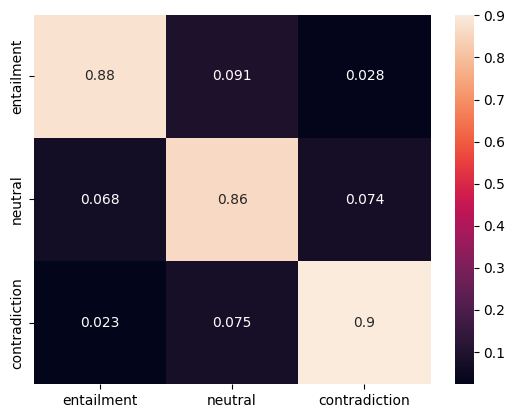

Epoch: 07 | Epoch Time: 18m 8s
	Train Loss: 0.123 | Train Acc: 95.98%
	 Val. Loss: 0.467 |  Val. Acc: 88.03%


 59%|█████▉    | 292/492 [00:17<00:12, 16.48it/s]

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/NLPProject/models/spanbertmore-nli_5.pt'))
for epoch in range(N_EPOCHS,N_EPOCHS+6):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, scheduler)
    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLPProject/models/spanbertmore-nli_{epoch}.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/NLPProject/models/spanbertmore-nli_5.pt'))

test_loss, test_acc = evaluate(model, test_dataloader, criterion)

print(f'Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

In [ ]:
index2label={0:"entailment",1:"neutral",2:"contradiction"}
def predict_inference(premise, hypothesis, model, device):
    
    model.eval()
    
    premise = '[CLS] ' + premise + ' [SEP]'
    hypothesis = hypothesis + ' [SEP]'
    
    prem_t = tokenize_bert(premise)
    hypo_t = tokenize_bert(hypothesis)
    
    #print(len(prem_t), len(hypo_t))
    
    prem_type = get_sent1_token_type(prem_t)
    hypo_type = get_sent2_token_type(hypo_t)
    
    #print(len(prem_type), len(hypo_type))
    
    indexes = prem_t + hypo_t
    
    indexes = tokenizer.convert_tokens_to_ids(indexes)
    #print(indexes)
    indexes_type = prem_type + hypo_type
    #print(indexes_type)
    
    attn_mask = get_sent2_token_type(indexes)
    #print(attn_mask)
    
    #print(len(indexes))
    #print(len(indexes_type))
    #print(len(attn_mask))

    #seq = '[CLS] '+ premise + ' [SEP] '+ hypothesis 

    #tokens = tokenizer.tokenize(seq)

    #indexes = tokenizer.convert_tokens_to_ids(tokens)
    
    indexes = torch.LongTensor(indexes).unsqueeze(0).to(device)
    indexes_type = torch.LongTensor(indexes_type).unsqueeze(0).to(device)
    attn_mask = torch.LongTensor(attn_mask).unsqueeze(0).to(device)
    
    #print(indexes.size())
    
    prediction = model(indexes, attn_mask, indexes_type)
    
    prediction = prediction.argmax(dim=-1).item()
    
    return index2label[prediction]

In [ ]:
premise = 'a man sitting on a green bench.'
hypothesis = 'a woman sitting on a green bench.'

predict_inference(premise, hypothesis, model, device)

In [ ]:
premise = 'a man sitting on a green bench.'
hypothesis = 'a man sitting on a blue bench.'

predict_inference(premise, hypothesis, model, device)

In [ ]:
premise = 'I am lying down on bed.'
hypothesis = 'I am resting on bed.'

predict_inference(premise, hypothesis, model, device)

In [ ]:
premise = 'I go to office on my personal car.'
hypothesis = 'I have to share office cab for reaching office.'

predict_inference(premise, hypothesis, model, device)

In [ ]:
premise = 'I love to play cricket.'
hypothesis = 'I enjoy playing football.'

predict_inference(premise, hypothesis, model, device)

In [ ]:
premise = 'He is techy.'
hypothesis = 'He has no idea of tech.'

predict_inference(premise, hypothesis, model, device)

In [ ]:
premise = 'I am using mobile phone.'
hypothesis = 'I have mobile in my hand.'

predict_inference(premise, hypothesis, model, device)